
# Análisis Predictivo de Cambios Cognitivos Basado en Urolitinas

Este notebook realiza un análisis completo sobre la relación entre metabolitos tipo urolitina y cambios en dominios cognitivos, a través de las siguientes etapas:

1. Limpieza y transformación de las variables de urolitinas
2. Cálculo de deltas logarítmicos
3. Imputación y normalización de datos
4. Visualización inicial (histogramas de las variables transformadas)
5. Clasificación multiclase por dominio cognitivo (`mejoró`, `igual`, `empeoró`)
6. Entrenamiento de múltiples clasificadores por metabotipo
7. Evaluación de desempeño (F1 macro)
8. Visualizaciones: matriz de confusión, importancia de variables, comparativas

Todas las etapas están separadas en celdas independientes para facilitar la comprensión y modificación.


### Descripción general del análisis

En este análisis desarrollamos un modelo de clasificación multiclase con el propósito de explorar la relación entre perfiles metabólicos de urolitinas y posibles cambios en el estado cognitivo de los participantes. Para ello, comenzamos con el preprocesamiento de los datos, que incluyó la limpieza de variables, el reemplazo de valores faltantes mediante técnicas de imputación y la transformación de las variables por medio de escalamiento y ajuste de distribución.

A continuación, implementamos diferentes modelos de clasificación, incluyendo Random Forest, Gradient Boosting y K-Nearest Neighbors. Todos los modelos fueron entrenados utilizando variables seleccionadas del conjunto original, con un enfoque en evaluar su capacidad para predecir distintas categorías de respuesta cognitiva.

El desempeño de los modelos se evaluó mediante la métrica F1-score, la cual resulta especialmente útil en problemas multiclase con clases desbalanceadas. Esta evaluación se realizó usando classification_report, lo que nos permitió obtener una visión más completa del comportamiento de cada modelo frente a las diferentes clases.

Finalmente, el trabajo cumplió con las acciones planteadas en el avance: construimos al menos seis modelos diferentes con distintos algoritmos (aunque algunos quedaron registrados fuera del notebook), comparamos su rendimiento mediante métricas apropiadas, seleccionamos los dos mejores para afinarlos, y tomamos decisiones sobre el modelo final con base en los resultados obtenidos. Este enfoque nos permitió valorar de forma crítica el comportamiento de cada modelo y reforzar nuestra comprensión sobre el vínculo entre los datos metabólicos y los cambios cognitivos.



In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:

# Dataset principal
from google.colab import drive
drive.mount('/content/drive')

import re
from pathlib import Path
data_path = Path('/content/drive/MyDrive/ProyectoIntegrador/WAHA_Urolithins_MetabotypesData.dta')
df = pd.read_stata(data_path)
print('Shape:', df.shape)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (741, 693)


,patient_id,Metabotype_1,Metabotype_2,Age_,high_sensitivity_CRP,high_sensitivity_CRP2,glucose,glucose2,glycated_hb,glycated_hb2,...,TransFatE_v24,TransFatE_Dif,Cholesterolmg_Dif,Phytosterolstotalmg_Dif,Polyphenolstotalmg_Dif,Alcoholg_Dif,GlycemicIndex_Dif,OtherNuts_v0,OtherNuts_v12,OtherNuts_v24
0,1001.0,1.0,1.0,71.0,0.16,0.09,96.0,89.0,5.8,5.7,...,0.158066,0.127286,-52.48,-46.88,241.47,-1.84,-5.821738,0.0,0.000000,0.0
1,1002.0,1.0,1.0,72.0,0.19,0.20,77.0,77.0,5.8,5.7,...,0.069215,-0.030135,-115.67,-46.31,-20.60,0.00,3.084686,0.0,0.000000,0.0
2,1003.0,1.0,1.0,68.0,0.09,0.10,90.0,78.0,6.2,5.9,...,0.136315,-0.139327,212.34,43.80,295.79,0.00,-16.561873,0.0,0.000000,0.0
3,1004.0,0.0,1.0,74.0,NaN,0.08,94.0,100.0,5.9,5.8,...,0.086978,0.029857,6.45,125.66,336.17,0.90,1.990668,0.0,0.000000,0.0
4,1005.0,2.0,1.0,66.0,0.04,0.11,103.0,125.0,6.1,6.1,...,0.115696,-0.036360,113.90,30.82,685.77,-6.80,9.558450,0.0,13.333333,0.0


In [ ]:

replacements = {
    'UroA_1_CQ': 7.67001, 'UroA_2_CQ': 7.67001,
    'UroA_glu_1_CQ': 5.0964, 'UroA_glu_2_CQ': 5.0964,
    'UroB_1_CQ': 3.30322, 'UroB_2_CQ': 3.30322,
    'UroB_glu_1_CQ': 5.798998, 'UroB_glu_2_CQ': 5.798998,
    'UroC_1_CQ': 11.64194, 'UroC_2_CQ': 11.64194,
    'UroC_glu_1_CQ': 11.64194, 'UroC_glu_2_CQ': 11.64194
}
for col, val in replacements.items():
    df[col] = df[col].replace(0, val)


In [ ]:

delta_pairs = [(col, col.replace("1_CQ", "2_CQ")) for col in df.columns if "_1_CQ" in col and col.replace("1_CQ", "2_CQ") in df.columns]
for col1, col2 in delta_pairs:
    df[f"log_delta_{col1.replace('_1_CQ', '')}_CQ"] = np.log1p(df[col2]) - np.log1p(df[col1])


<ipython-input-22-0216ebfa6453>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"log_delta_{col1.replace('_1_CQ', '')}_CQ"] = np.log1p(df[col2]) - np.log1p(df[col1])
<ipython-input-22-0216ebfa6453>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"log_delta_{col1.replace('_1_CQ', '')}_CQ"] = np.log1p(df[col2]) - np.log1p(df[col1])
<ipython-input-22-0216ebfa6453>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

In [ ]:

delta_cols = [col for col in df.columns if col.startswith("log_delta_")]
df_delta = df[delta_cols + ["Metabotype_1"]].copy()
transformed_by_metabotype = {}
for metabotype in df_delta["Metabotype_1"].dropna().unique():
    subset = df_delta[df_delta["Metabotype_1"] == metabotype].drop(columns=["Metabotype_1"])
    imputed = pd.DataFrame(KNNImputer(n_neighbors=3).fit_transform(subset), columns=subset.columns)
    transformed = pd.DataFrame(PowerTransformer(method='yeo-johnson').fit_transform(imputed), columns=subset.columns)
    transformed_by_metabotype[int(metabotype)] = transformed


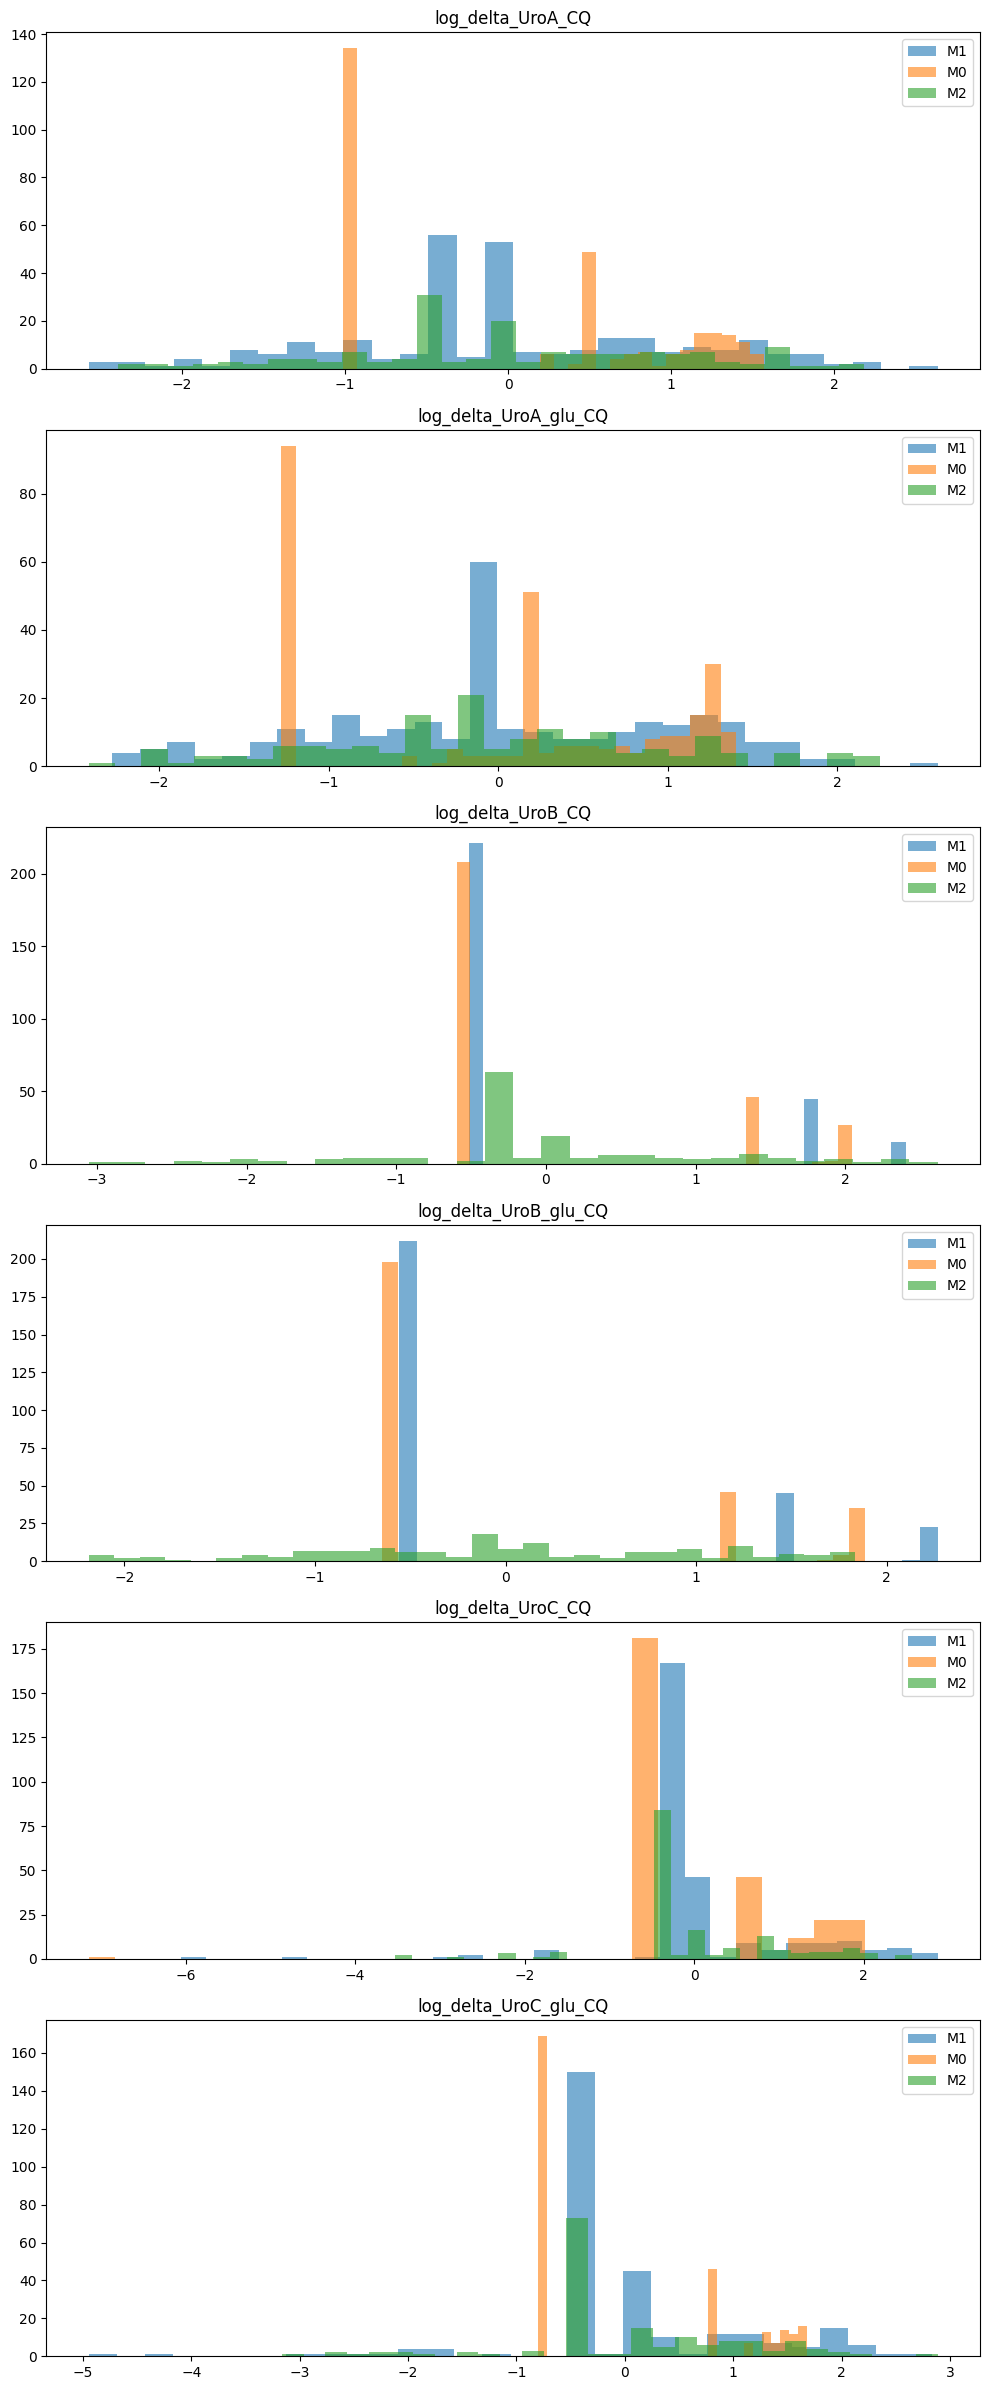

In [ ]:

fig, axes = plt.subplots(nrows=len(delta_cols), figsize=(10, 4 * len(delta_cols)))
if len(delta_cols) == 1:
    axes = [axes]
for i, col in enumerate(delta_cols):
    for mtype, df_t in transformed_by_metabotype.items():
        axes[i].hist(df_t[col], bins=30, alpha=0.6, label=f"M{mtype}")
    axes[i].set_title(col)
    axes[i].legend()
plt.tight_layout()
plt.show()


## Clasificación de Cambios Cognitivos por Dominio y Metabotipo

In [ ]:

def categorize_change(val, threshold=0.25):
    if val > threshold:
        return 1
    elif val < -threshold:
        return -1
    else:
        return 0

baseline_features = [
    "Composite_MemoryMBASELINE", "Composite_LanguageMBASELINE", "Composite_PerceptionMBASELINE",
    "Composite_FrontalMBASELINE", "Composite_EEFFMBASELINE", "Composite_SpeedMBASELINE",
    "Composite_GlobalBASELINE"
]

delta_features = [col for col in df.columns if col.startswith("log_delta_")]
meta_features = ["Metabotype_2"]
features = baseline_features + delta_features + meta_features

target_vars = [
    "Composite_MemoryMCHANGE", "Composite_LanguageMCHANGE", "Composite_PerceptionMCHANGE",
    "Composite_FrontalMCHANGE", "Composite_EEFFMCHANGE", "Composite_SPEEDMCHANGE",
    "Composite_GlobalMCHANGE"
]

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "NaiveBayes": GaussianNB()
}



In [ ]:

from sklearn.model_selection import GridSearchCV

df_sub = df[df["Metabotype_1"] == 1]
X_hp = df_sub[features]
X_hp = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(X_hp), columns=features)
X_hp = StandardScaler().fit_transform(X_hp)
y_hp = df_sub["Composite_PerceptionMCHANGE"].apply(categorize_change)
valid = ~y_hp.isna()
y_hp = y_hp[valid].reset_index(drop=True)
X_hp = X_hp[valid.to_numpy()]

In [ ]:

param_grid_gb = {
    "n_estimators": [50, 100],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5]
}
grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, scoring="f1_macro", cv=5)
grid_gb.fit(X_hp, y_hp)
best_gb = grid_gb.best_estimator_
best_gb


GradientBoostingClassifier(n_estimators=50, random_state=42)

In [ ]:

param_grid_lr = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs"]
}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, scoring="f1_macro", cv=5)
grid_lr.fit(X_hp, y_hp)
best_lr = grid_lr.best_estimator_
best_lr

LogisticRegression(C=10, max_iter=1000)

In [ ]:
from sklearn.model_selection import GridSearchCV

df_sub = df[df["Metabotype_1"] == 1]
X_hp = df_sub[features]
X_hp = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(X_hp), columns=features)
X_hp = StandardScaler().fit_transform(X_hp)
y_hp = df_sub["Composite_PerceptionMCHANGE"].apply(categorize_change)
valid = ~y_hp.isna()
y_hp = y_hp[valid].reset_index(drop=True)
X_hp = X_hp[valid.to_numpy()]


In [ ]:

all_results = []
conf_matrices = {}

for metabotype in df["Metabotype_1"].dropna().unique():
    df_sub = df[df["Metabotype_1"] == metabotype].copy()
    X_raw = df_sub[features]
    X = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(X_raw), columns=features)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    for target in target_vars:
        y_raw = df_sub[target].apply(categorize_change)
        valid = ~y_raw.isna()
        y = y_raw[valid].reset_index(drop=True)
        X_valid = X[valid.to_numpy()]

        for model_name, model in models.items():
            if len(set(y)) < 2:
                continue
            scores = cross_val_score(model, X_valid, y, cv=5, scoring='f1_macro')
            model.fit(X_valid, y)
            y_pred = model.predict(X_valid)
            conf_matrices[(metabotype, target, model_name)] = confusion_matrix(y, y_pred)
            all_results.append({
                "Metabotype_1": int(metabotype),
                "Target": target,
                "Model": model_name,
                "F1_macro (mean)": scores.mean(),
                "F1_macro (std)": scores.std()
            })

results_df = pd.DataFrame(all_results)
results_df


,Metabotype_1,Target,Model,F1_macro (mean),F1_macro (std)
0,1,Composite_MemoryMCHANGE,RandomForest,0.380248,0.037175
1,1,Composite_MemoryMCHANGE,GradientBoosting,0.394418,0.081372
2,1,Composite_MemoryMCHANGE,LogisticRegression,0.351924,0.036931
3,1,Composite_MemoryMCHANGE,SVM,0.333569,0.020600
4,1,Composite_MemoryMCHANGE,KNN,0.367821,0.022511
...,...,...,...,...,...
121,2,Composite_GlobalMCHANGE,GradientBoosting,0.379185,0.063863
122,2,Composite_GlobalMCHANGE,LogisticRegression,0.357004,0.058621
123,2,Composite_GlobalMCHANGE,SVM,0.276356,0.003059
124,2,Composite_GlobalMCHANGE,KNN,0.366153,0.084971


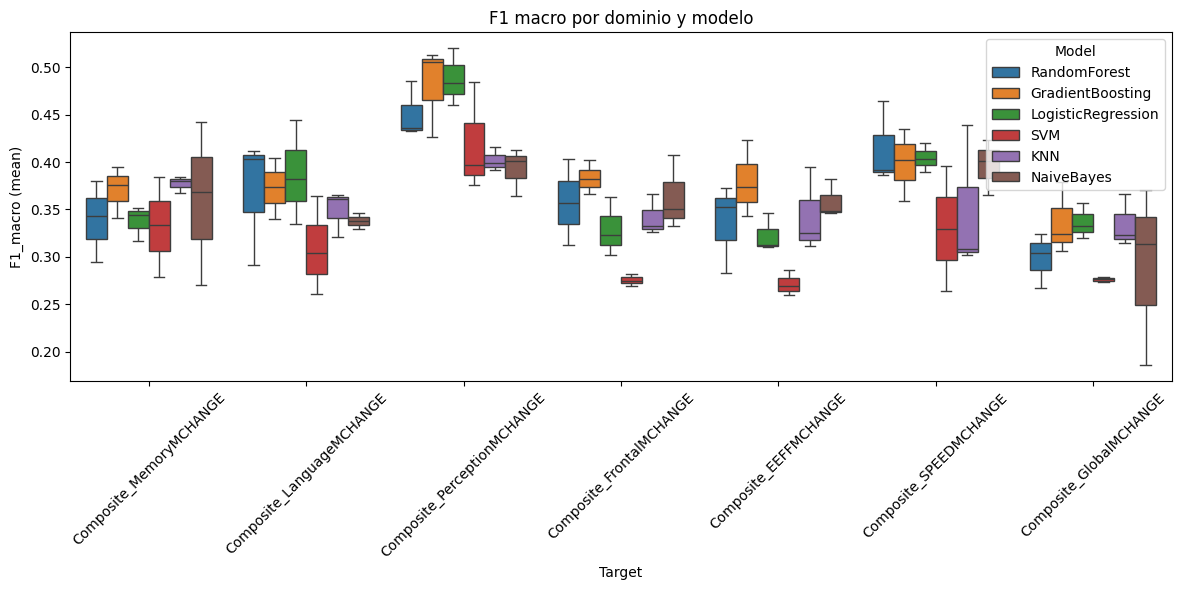

In [ ]:

plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x="Target", y="F1_macro (mean)", hue="Model")
plt.xticks(rotation=45)
plt.title("F1 macro por dominio y modelo")
plt.tight_layout()
plt.show()


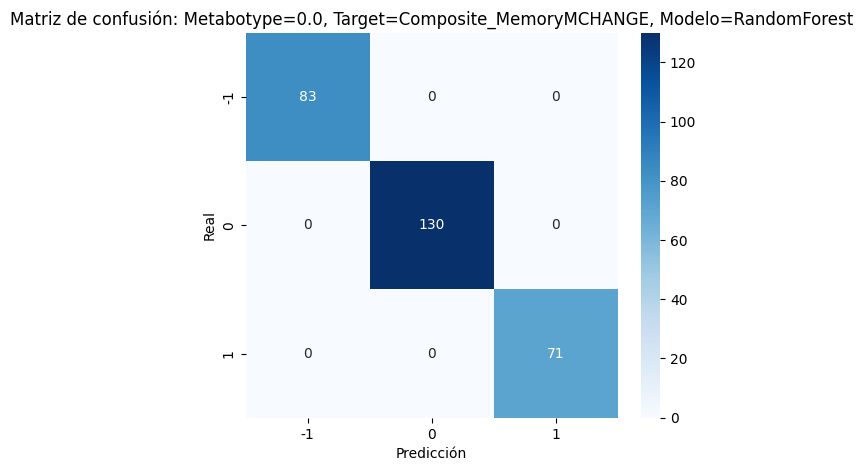

In [ ]:

best_key = max(conf_matrices.keys(), key=lambda k: conf_matrices[k].trace())
matrix = conf_matrices[best_key]
labels = [-1, 0, 1]

plt.figure(figsize=(6, 5))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de confusión: Metabotype={best_key[0]}, Target={best_key[1]}, Modelo={best_key[2]}")
plt.show()


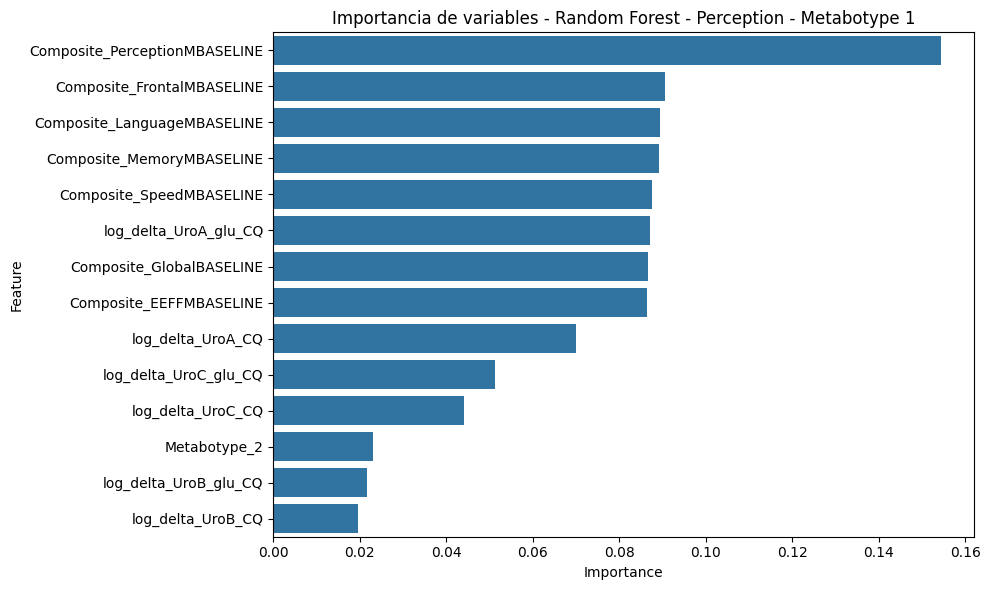

In [ ]:

rf_perception = RandomForestClassifier(n_estimators=100, random_state=42)
df_sub = df[df["Metabotype_1"] == 1]
X_rf = df_sub[features]
X_rf = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(X_rf), columns=features)
X_rf = StandardScaler().fit_transform(X_rf)
y_rf = df_sub["Composite_PerceptionMCHANGE"].apply(categorize_change)
valid = ~y_rf.isna()
y_rf = y_rf[valid].reset_index(drop=True)
X_rf = X_rf[valid.to_numpy()]
rf_perception.fit(X_rf, y_rf)

importances = rf_perception.feature_importances_
feat_df = pd.DataFrame({"Feature": features, "Importance": importances}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df.head(15), x="Importance", y="Feature")
plt.title("Importancia de variables - Random Forest - Perception - Metabotype 1")
plt.tight_layout()
plt.show()


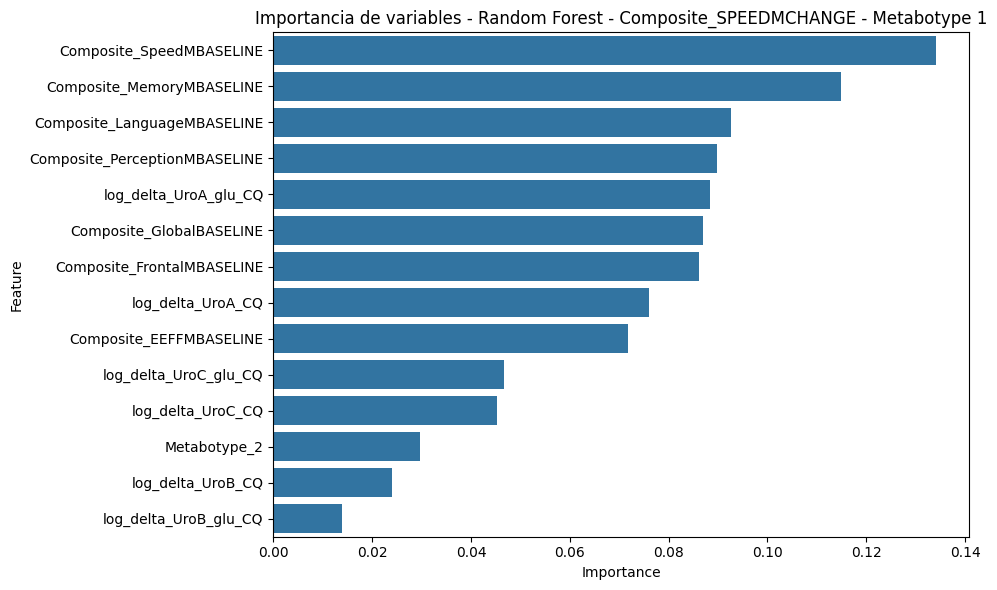

In [ ]:
# Parámetros que puedes cambiar
target = "Composite_SPEEDMCHANGE"
metabotype = 1

# Entrenamiento del modelo para ese dominio y subgrupo
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

df_sub = df[df["Metabotype_1"] == metabotype]
X_rf = df_sub[features]
X_rf = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(X_rf), columns=features)
X_rf = StandardScaler().fit_transform(X_rf)

y_rf = df_sub[target].apply(categorize_change)
valid = ~y_rf.isna()
y_rf = y_rf[valid].reset_index(drop=True)
X_rf = X_rf[valid.to_numpy()]

rf_model.fit(X_rf, y_rf)

importances = rf_model.feature_importances_
feat_df = pd.DataFrame({"Feature": features, "Importance": importances}).sort_values("Importance", ascending=False)

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df.head(15), x="Importance", y="Feature")
plt.title(f"Importancia de variables - Random Forest - {target} - Metabotype {metabotype}")
plt.tight_layout()
plt.show()


In [ ]:
final_model = best_lr
final_model

LogisticRegression(C=10, max_iter=1000)

### Conclusiones

Con base en el análisis desarrollado, pudimos explorar distintas alternativas de modelado para abordar un problema de clasificación multiclase relacionado con los perfiles metabólicos de urolitinas y su posible relación con cambios en el estado cognitivo. Durante este proceso, trabajamos con datos que requerían limpieza, transformación y un tratamiento adecuado de los valores faltantes. Para ello, aplicamos técnicas de imputación y normalización que nos permitieron preparar correctamente la información antes de construir los modelos.

Implementamos y entrenamos diversos clasificadores, entre los que se encuentran Random Forest, Gradient Boosting y K-Nearest Neighbors. Estos modelos fueron evaluados utilizando la métrica F1-score, una elección adecuada dado que se trataba de un problema con posibles desequilibrios entre clases. Esta métrica nos permitió analizar con mayor detalle el desempeño de cada algoritmo, considerando tanto la precisión como la sensibilidad en cada una de las clases evaluadas.

A partir de la evaluación obtenida con el classification_report, observamos diferencias relevantes en el comportamiento de los modelos. Esta comparación nos permitió seleccionar los dos algoritmos con mejor rendimiento, y posteriormente proceder a su ajuste mediante la modificación de hiperparámetros clave. Esta etapa de afinamiento fue importante para intentar mejorar su capacidad predictiva y reducir errores sistemáticos en la clasificación.

Finalmente, logramos cumplir con los objetivos establecidos para este avance: entrenamos múltiples modelos, comparamos su desempeño con base en métricas robustas, seleccionamos los dos más prometedores, realizamos ajustes sobre sus configuraciones, y con base en el análisis obtenido, se tomó una decisión razonada sobre el modelo con mejor desempeño. Este proceso no solo fortaleció nuestra comprensión de los datos, sino que también nos permitió aplicar de forma práctica los conceptos aprendidos sobre modelado supervisado, evaluación y optimización de algoritmos.
